In [59]:
import numpy as np
import pandas as pd
import os
import ast
import datetime
from os.path import isfile, join
from tqdm import tqdm
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from openpyxl import load_workbook
from collections import Counter
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import LabelEncoder
import warnings 
warnings.filterwarnings('ignore')

os.chdir('G:/Shared drives/CKD_Progression/')
fontname = 'Arial'

drive = 'G'
main_path = drive + ':/Shared drives/CKD_Progression/data/CKD_COHORT_Jan2010_Mar2024_v3.csv'
data_path = drive + ':/Shared drives/CKD_Progression/data/'
docs_path = drive + ':/Shared drives/CKD_Progression/docs/'
save_path = drive + ':/Shared drives/CKD_Progression/save/'
covariates_path = docs_path + 'covariates.csv'
removecols_path = docs_path + 'remove_columns.csv'

def get_patients_new():
    folder_path = save_path + 'cohort_patients.csv'
    df = pd.read_csv(folder_path, encoding = 'utf-8')
    df = df.drop_duplicates()
    patient_list_flag = df['ENC_HN'].unique().tolist()
    return patient_list_flag

def log_rank_test(df, time1, time2, event1, event2):
    results = logrank_test(df[time1], df[time2], 
                           event_observed_A = df[event1],
                           event_observed_B = df[event2])
    print(f'Log-rank test of {event1} and {event2} is {np.round(results.test_statistic, 3)} with {results.p_value} p-value.')
    return results

def generate_kmf(df, time, event, label):
    kmf = KaplanMeierFitter()
    mask = df[time] != 0
    df = df[mask]
    T, E = df[time] / 12, df[event]
    return kmf.fit(T, E, label = label)

def generate_naf(df, time, event, label):
    naf = NelsonAalenFitter()
    T, E = df[time] / 12, df[event]
    return naf.fit(T, E, label = label)

def replace_zeros_with_ones(df, column_name):
    df[column_name] = df[column_name].replace(0, 0)
    return df


patients = get_patients_new() 
assert pd.Series(patients).nunique() == 23693

In [60]:
df_raw = pd.read_csv(save_path + 'multistage_ver007.csv')
transitions_months = df_raw.columns[20:]
df_raw = replace_zeros_with_ones(df_raw, transitions_months)

In [84]:
kmf_ckd3b = generate_kmf(df_raw, time = 'ckd3a_to_ckd3b_months', event = 'CKD3B_status', label = 'CKD3B')
kmf_ckd04 = generate_kmf(df_raw, time = 'ckd3a_to_ckd04_months', event = 'CKD04_status', label = 'CKD4')
kmf_ckd5a = generate_kmf(df_raw, time = 'ckd3a_to_ckd5a_months', event = 'CKD5A_status', label = 'CKD5A')
kmf_ckd5b = generate_kmf(df_raw, time = 'ckd3a_to_ckd5b_months', event = 'CKD5B_status', label = 'CKD5B')
kmf_cvd00 = generate_kmf(df_raw, time = 'ckd3a_to_cvd00_months', event = 'CVD00_status', label = 'CVD' )
kmf_death = generate_kmf(df_raw, time = 'ckd3a_to_death_months', event = 'DEATH_status', label = 'DEATH')

kmf_ckd3b_df = kmf_ckd3b.survival_function_.reset_index()
kmf_ckd04_df = kmf_ckd04.survival_function_.reset_index()
kmf_ckd5a_df = kmf_ckd5a.survival_function_.reset_index()
kmf_ckd5b_df = kmf_ckd5b.survival_function_.reset_index()
kmf_cvd00_df = kmf_cvd00.survival_function_.reset_index()
kmf_death_df = kmf_death.survival_function_.reset_index()

merged_kmf_from_ckd3a = pd.merge(kmf_ckd3b_df, kmf_ckd04_df, on = 'timeline')
merged_kmf_from_ckd3a = pd.merge(merged_kmf_from_ckd3a, kmf_ckd5a_df, on = 'timeline')
merged_kmf_from_ckd3a = pd.merge(merged_kmf_from_ckd3a, kmf_ckd5b_df, on = 'timeline')
merged_kmf_from_ckd3a = pd.merge(merged_kmf_from_ckd3a, kmf_cvd00_df, on = 'timeline')
merged_kmf_from_ckd3a = pd.merge(merged_kmf_from_ckd3a, kmf_death_df, on = 'timeline')

merged_kmf_from_ckd3a = merged_kmf_from_ckd3a[merged_kmf_from_ckd3a['timeline'].isin(np.arange(1, 11, 1))] 
merged_kmf_from_ckd3a.iloc[:, 1:] = 1 - merged_kmf_from_ckd3a.iloc[:, 1:]
merged_kmf_from_ckd3a.to_csv(save_path + 'KM_CKD3A.csv', index = False)

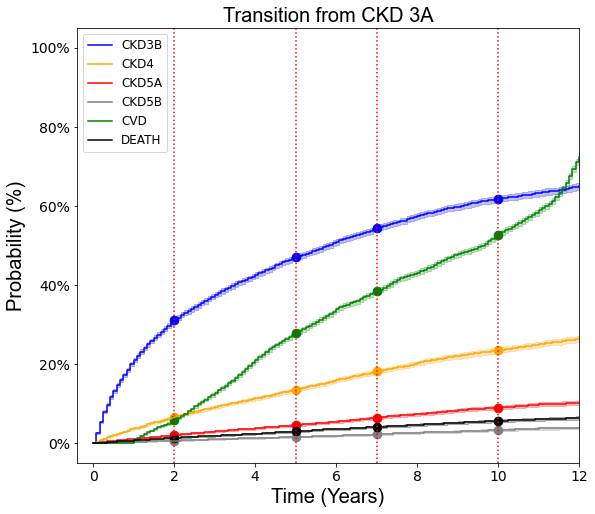

In [87]:
plt.figure(figsize = (9, 8))
ax = kmf_ckd3b.plot_cumulative_density(color = 'blue')
ax = kmf_ckd04.plot_cumulative_density(ax = ax, color = 'orange')
ax = kmf_ckd5a.plot_cumulative_density(ax = ax, color = 'red')
ax = kmf_ckd5b.plot_cumulative_density(ax = ax, color = 'gray')
ax = kmf_cvd00.plot_cumulative_density(ax = ax, color = 'green')
ax = kmf_death.plot_cumulative_density(ax = ax, color = 'black')

time_deltas = [2, 5, 7, 10]
for time_delta in time_deltas:
    plt.axvline(x=time_delta, color='red', linestyle='dotted', lw = 1.5)
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3a.loc[merged_kmf_from_ckd3a['timeline'] == time_delta, 'CKD3B'].values[0]], s=75, c='blue')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3a.loc[merged_kmf_from_ckd3a['timeline'] == time_delta,  'CKD4'].values[0]], s=75, c='orange')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3a.loc[merged_kmf_from_ckd3a['timeline'] == time_delta, 'CKD5A'].values[0]], s=75, c='red')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3a.loc[merged_kmf_from_ckd3a['timeline'] == time_delta, 'CKD5B'].values[0]], s=75, c='gray')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3a.loc[merged_kmf_from_ckd3a['timeline'] == time_delta, 'CVD']  .values[0]], s=75, c='green')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3a.loc[merged_kmf_from_ckd3a['timeline'] == time_delta, 'DEATH'].values[0]], s=75, c='black')
    
plt.title('Transition from CKD 3A', size = 20, fontname = fontname)
plt.xlim(left = -0.4)
plt.xlabel('Time (Years)',    size = 20, fontname = fontname)
plt.ylabel('Probability (%)', size = 20, fontname = fontname)
plt.gca().set_yticklabels(['{:.0f}%'.format(y * 100) for y in plt.gca().get_yticks()])
leg = plt.legend(loc='upper left', fontsize='large', markerscale=1.5)  

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.xlim(right = 12)
plt.show()

In [89]:
kmf_ckd04 = generate_kmf(df_raw, time = 'ckd3b_to_ckd04_months', event = 'CKD04_status', label = 'CKD4')
kmf_ckd5a = generate_kmf(df_raw, time = 'ckd3b_to_ckd5a_months', event = 'CKD5A_status', label = 'CKD5A')
kmf_ckd5b = generate_kmf(df_raw, time = 'ckd3b_to_ckd5b_months', event = 'CKD5B_status', label = 'CKD5B')
kmf_cvd00 = generate_kmf(df_raw, time = 'ckd3b_to_cvd00_months', event = 'CVD00_status', label = 'CVD' )
kmf_death = generate_kmf(df_raw, time = 'ckd3b_to_death_months', event = 'DEATH_status', label = 'DEATH')

kmf_ckd04_df = kmf_ckd04.survival_function_.reset_index()
kmf_ckd5a_df = kmf_ckd5a.survival_function_.reset_index()
kmf_ckd5b_df = kmf_ckd5b.survival_function_.reset_index()
kmf_cvd00_df = kmf_cvd00.survival_function_.reset_index()
kmf_death_df = kmf_death.survival_function_.reset_index()

merged_kmf_from_ckd3b = pd.merge(kmf_ckd04_df, kmf_ckd5a_df, on = 'timeline')
merged_kmf_from_ckd3b = pd.merge(merged_kmf_from_ckd3b, kmf_ckd5b_df, on = 'timeline')
merged_kmf_from_ckd3b = pd.merge(merged_kmf_from_ckd3b, kmf_cvd00_df, on = 'timeline')
merged_kmf_from_ckd3b = pd.merge(merged_kmf_from_ckd3b, kmf_death_df, on = 'timeline')

merged_kmf_from_ckd3b = merged_kmf_from_ckd3b[merged_kmf_from_ckd3b['timeline'].isin(np.arange(1, 11, 1))] 
merged_kmf_from_ckd3b.iloc[:, 1:] = 1 - merged_kmf_from_ckd3b.iloc[:, 1:]
merged_kmf_from_ckd3b.to_csv(save_path + 'KM_CKD3B.csv', index = False)

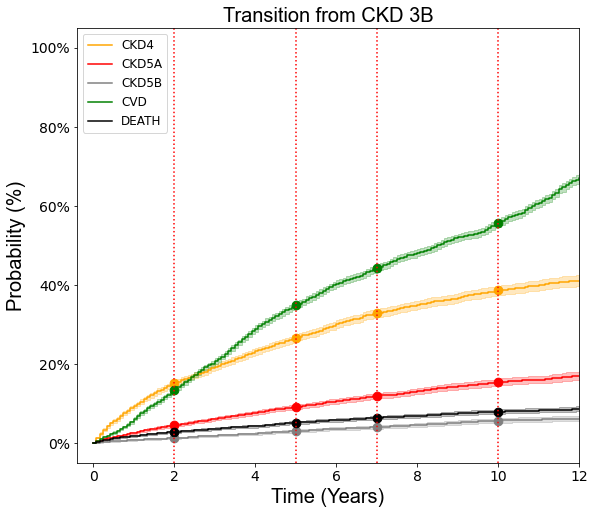

In [91]:
plt.figure(figsize = (9, 8))
ax = kmf_ckd04.plot_cumulative_density(color = 'orange')
ax = kmf_ckd5a.plot_cumulative_density(ax = ax, color = 'red')
ax = kmf_ckd5b.plot_cumulative_density(ax = ax, color = 'gray')
ax = kmf_cvd00.plot_cumulative_density(ax = ax, color = 'green')
ax = kmf_death.plot_cumulative_density(ax = ax, color = 'black')

time_deltas = [2, 5, 7, 10]
for time_delta in time_deltas:
    plt.axvline(x=time_delta, color='red', linestyle='dotted', lw = 1.5)
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3b.loc[merged_kmf_from_ckd3b['timeline'] == time_delta,  'CKD4'].values[0]], s=75, c='orange')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3b.loc[merged_kmf_from_ckd3b['timeline'] == time_delta, 'CKD5A'].values[0]], s=75, c='red')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3b.loc[merged_kmf_from_ckd3b['timeline'] == time_delta, 'CKD5B'].values[0]], s=75, c='gray')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3b.loc[merged_kmf_from_ckd3b['timeline'] == time_delta, 'CVD']  .values[0]], s=75, c='green')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd3b.loc[merged_kmf_from_ckd3b['timeline'] == time_delta, 'DEATH'].values[0]], s=75, c='black')
    
plt.title('Transition from CKD 3B', size = 20, fontname = fontname)
plt.xlim(left = -0.4)
plt.xlabel('Time (Years)',    size = 20, fontname = fontname)
plt.ylabel('Probability (%)', size = 20, fontname = fontname)
plt.gca().set_yticklabels(['{:.0f}%'.format(y * 100) for y in plt.gca().get_yticks()])
leg = plt.legend(loc='upper left', fontsize='large', markerscale=1.5)  

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.xlim(right = 12)
plt.show()

In [92]:
kmf_ckd5a = generate_kmf(df_raw, time = 'ckd04_to_ckd5a_months', event = 'CKD5A_status', label = 'CKD5A')
kmf_ckd5b = generate_kmf(df_raw, time = 'ckd04_to_ckd5b_months', event = 'CKD5B_status', label = 'CKD5B')
kmf_cvd00 = generate_kmf(df_raw, time = 'ckd04_to_cvd00_months', event = 'CVD00_status', label = 'CVD' )
kmf_death = generate_kmf(df_raw, time = 'ckd04_to_death_months', event = 'DEATH_status', label = 'DEATH')

kmf_ckd5a_df = kmf_ckd5a.survival_function_.reset_index()
kmf_ckd5b_df = kmf_ckd5b.survival_function_.reset_index()
kmf_cvd00_df = kmf_cvd00.survival_function_.reset_index()
kmf_death_df = kmf_death.survival_function_.reset_index()

merged_kmf_from_ckd04 = pd.merge(kmf_ckd5a_df, kmf_ckd5b_df, on = 'timeline')
merged_kmf_from_ckd04 = pd.merge(merged_kmf_from_ckd04, kmf_cvd00_df, on = 'timeline')
merged_kmf_from_ckd04 = pd.merge(merged_kmf_from_ckd04, kmf_death_df, on = 'timeline')

merged_kmf_from_ckd04 = merged_kmf_from_ckd04[merged_kmf_from_ckd04['timeline'].isin(np.arange(1, 11, 1))] 
merged_kmf_from_ckd04.iloc[:, 1:] = 1 - merged_kmf_from_ckd04.iloc[:, 1:]
merged_kmf_from_ckd3b.to_csv(save_path + 'KM_CKD04.csv', index = False)

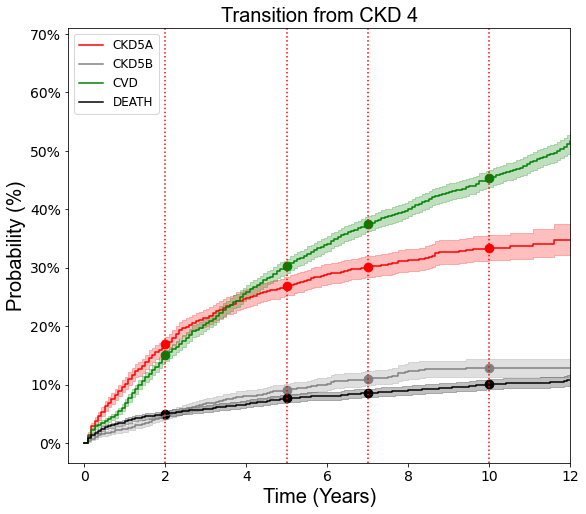

In [93]:
plt.figure(figsize = (9, 8))
ax = kmf_ckd5a.plot_cumulative_density(color = 'red')
ax = kmf_ckd5b.plot_cumulative_density(ax = ax, color = 'gray')
ax = kmf_cvd00.plot_cumulative_density(ax = ax, color = 'green')
ax = kmf_death.plot_cumulative_density(ax = ax, color = 'black')

time_deltas = [2, 5, 7, 10]
for time_delta in time_deltas:
    plt.axvline(x=time_delta, color='red', linestyle='dotted', lw = 1.5)
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd04.loc[merged_kmf_from_ckd04['timeline'] == time_delta, 'CKD5A'].values[0]], s=75, c='red')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd04.loc[merged_kmf_from_ckd04['timeline'] == time_delta, 'CKD5B'].values[0]], s=75, c='gray')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd04.loc[merged_kmf_from_ckd04['timeline'] == time_delta, 'CVD']  .values[0]], s=75, c='green')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd04.loc[merged_kmf_from_ckd04['timeline'] == time_delta, 'DEATH'].values[0]], s=75, c='black')
    
plt.title('Transition from CKD 4', size = 20, fontname = fontname)
plt.xlim(left = -0.4)
plt.xlabel('Time (Years)',    size = 20, fontname = fontname)
plt.ylabel('Probability (%)', size = 20, fontname = fontname)
plt.gca().set_yticklabels(['{:.0f}%'.format(y * 100) for y in plt.gca().get_yticks()])
leg = plt.legend(loc = 'upper left', fontsize = 'large')

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.xlim(right = 12)
plt.show()

In [94]:
kmf_ckd5b = generate_kmf(df_raw, time = 'ckd5a_to_ckd5b_months', event = 'CKD5B_status', label = 'CKD5B')
kmf_cvd00 = generate_kmf(df_raw, time = 'ckd5a_to_cvd00_months', event = 'CVD00_status', label = 'CVD' )
kmf_death = generate_kmf(df_raw, time = 'ckd5a_to_death_months', event = 'DEATH_status', label = 'DEATH')

kmf_ckd5b_df = kmf_ckd5b.survival_function_.reset_index()
kmf_cvd00_df = kmf_cvd00.survival_function_.reset_index()
kmf_death_df = kmf_death.survival_function_.reset_index()

merged_kmf_from_ckd5a = pd.merge(kmf_ckd5b_df, kmf_cvd00_df, on = 'timeline')
merged_kmf_from_ckd5a = pd.merge(merged_kmf_from_ckd5a, kmf_death_df, on = 'timeline')

merged_kmf_from_ckd5a = merged_kmf_from_ckd5a[merged_kmf_from_ckd5a['timeline'].isin(np.arange(1, 11, 1))] 
merged_kmf_from_ckd5a.iloc[:, 1:] = 1 - merged_kmf_from_ckd5a.iloc[:, 1:]
merged_kmf_from_ckd5a.to_csv(save_path + 'KM_CKD5A.csv', index = False)

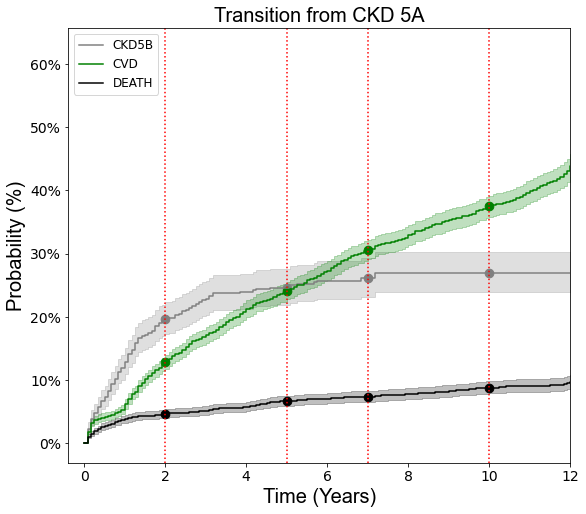

In [95]:
plt.figure(figsize = (9, 8))
ax = kmf_ckd5b.plot_cumulative_density(color = 'gray')
ax = kmf_cvd00.plot_cumulative_density(ax = ax, color = 'green')
ax = kmf_death.plot_cumulative_density(ax = ax, color = 'black')

time_deltas = [2, 5, 7, 10]
for time_delta in time_deltas:
    plt.axvline(x=time_delta, color='red', linestyle='dotted', lw = 1.5)
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd5a.loc[merged_kmf_from_ckd5a['timeline'] == time_delta, 'CKD5B'].values[0]], s=75, c='gray')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd5a.loc[merged_kmf_from_ckd5a['timeline'] == time_delta, 'CVD']  .values[0]], s=75, c='green')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd5a.loc[merged_kmf_from_ckd5a['timeline'] == time_delta, 'DEATH'].values[0]], s=75, c='black')
    
plt.title('Transition from CKD 5A', size = 20, fontname = fontname)
plt.xlim(left = -0.4)
plt.xlabel('Time (Years)',    size = 20, fontname = fontname)
plt.ylabel('Probability (%)', size = 20, fontname = fontname)
plt.gca().set_yticklabels(['{:.0f}%'.format(y * 100) for y in plt.gca().get_yticks()])
leg = plt.legend(loc = 'upper left', fontsize = 'large')

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.xlim(right = 12)
plt.show()

In [96]:
kmf_cvd00 = generate_kmf(df_raw, time = 'ckd5b_to_cvd00_months', event = 'CVD00_status', label = 'CVD' )
kmf_death = generate_kmf(df_raw, time = 'ckd5b_to_death_months', event = 'DEATH_status', label = 'DEATH')

kmf_cvd00_df = kmf_cvd00.survival_function_.reset_index()
kmf_death_df = kmf_death.survival_function_.reset_index()

merged_kmf_from_ckd5b = pd.merge(kmf_cvd00_df, kmf_death_df, on = 'timeline')

merged_kmf_from_ckd5b = merged_kmf_from_ckd5b[merged_kmf_from_ckd5b['timeline'].isin(np.arange(1, 11, 1))] 
merged_kmf_from_ckd5b.iloc[:, 1:] = 1 - merged_kmf_from_ckd5b.iloc[:, 1:]
merged_kmf_from_ckd5b.to_csv(save_path + 'KM_CKD5B.csv', index = False)

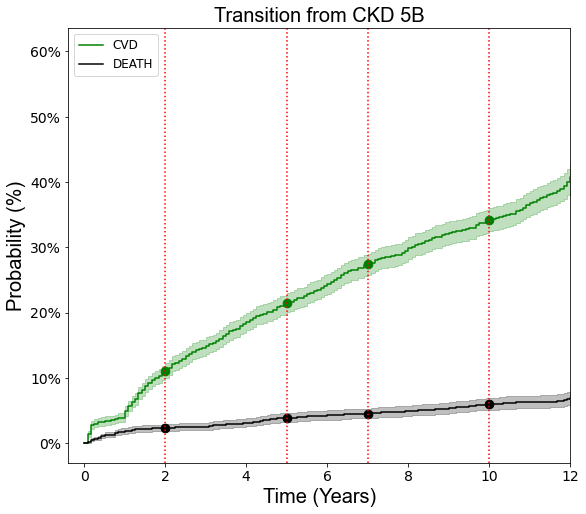

In [98]:
plt.figure(figsize = (9, 8))
ax = kmf_cvd00.plot_cumulative_density(color = 'green')
ax = kmf_death.plot_cumulative_density(ax = ax, color = 'black')

time_deltas = [2, 5, 7, 10]
for time_delta in time_deltas:
    plt.axvline(x=time_delta, color='red', linestyle='dotted', lw = 1.5)
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd5b.loc[merged_kmf_from_ckd5b['timeline'] == time_delta, 'CVD']  .values[0]], s=75, c='green')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_ckd5b.loc[merged_kmf_from_ckd5b['timeline'] == time_delta, 'DEATH'].values[0]], s=75, c='black')
    
plt.title('Transition from CKD 5B', size = 20, fontname = fontname)
plt.xlim(left = -0.4)
plt.xlabel('Time (Years)',    size = 20, fontname = fontname)
plt.ylabel('Probability (%)', size = 20, fontname = fontname)
plt.gca().set_yticklabels(['{:.0f}%'.format(y * 100) for y in plt.gca().get_yticks()])
leg = plt.legend(loc = 'upper left', fontsize = 'large')

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.xlim(right = 12)
plt.show()

In [99]:
kmf_ckd3b = generate_kmf(df_raw, time = 'cvd00_to_ckd3b_months', event = 'CKD3B_status', label = 'CKD3B')
kmf_ckd04 = generate_kmf(df_raw, time = 'cvd00_to_ckd04_months', event = 'CKD04_status', label = 'CKD4')
kmf_ckd5a = generate_kmf(df_raw, time = 'cvd00_to_ckd5a_months', event = 'CKD5A_status', label = 'CKD5A')
kmf_ckd5b = generate_kmf(df_raw, time = 'cvd00_to_ckd5b_months', event = 'CKD5B_status', label = 'CKD5B')
kmf_death = generate_kmf(df_raw, time = 'cvd00_to_death_months', event = 'DEATH_status', label = 'DEATH')

kmf_ckd3b_df = kmf_ckd3b.survival_function_.reset_index()
kmf_ckd04_df = kmf_ckd04.survival_function_.reset_index()
kmf_ckd5a_df = kmf_ckd5a.survival_function_.reset_index()
kmf_ckd5b_df = kmf_ckd5b.survival_function_.reset_index()
kmf_death_df = kmf_death.survival_function_.reset_index()

merged_kmf_from_cvd00 = pd.merge(kmf_ckd3b_df, kmf_ckd04_df, on = 'timeline')
merged_kmf_from_cvd00 = pd.merge(merged_kmf_from_cvd00, kmf_ckd5a_df, on = 'timeline')
merged_kmf_from_cvd00 = pd.merge(merged_kmf_from_cvd00, kmf_ckd5b_df, on = 'timeline')
merged_kmf_from_cvd00 = pd.merge(merged_kmf_from_cvd00, kmf_death_df, on = 'timeline')

merged_kmf_from_cvd00 = merged_kmf_from_cvd00[merged_kmf_from_cvd00['timeline'].isin(np.arange(1, 11, 1))] 
merged_kmf_from_cvd00.iloc[:, 1:] = 1 - merged_kmf_from_cvd00.iloc[:, 1:]
merged_kmf_from_cvd00.to_csv(save_path + 'KM_CVD00.csv', index = False)

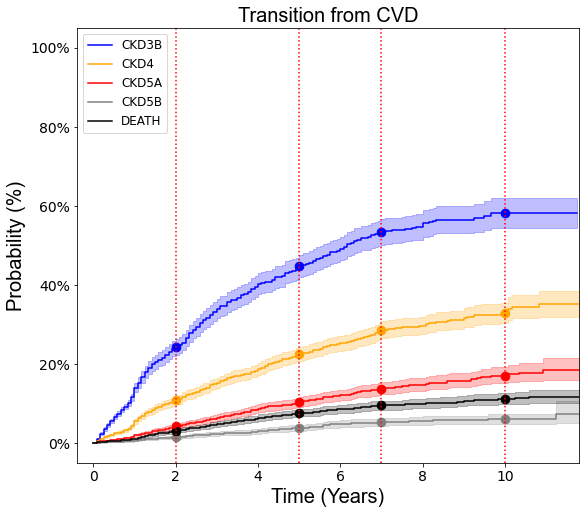

In [101]:
plt.figure(figsize = (9, 8))
ax = kmf_ckd3b.plot_cumulative_density(color = 'blue')
ax = kmf_ckd04.plot_cumulative_density(ax = ax, color = 'orange')
ax = kmf_ckd5a.plot_cumulative_density(ax = ax, color = 'red')
ax = kmf_ckd5b.plot_cumulative_density(ax = ax, color = 'gray')
ax = kmf_death.plot_cumulative_density(ax = ax, color = 'black')

time_deltas = [2, 5, 7, 10]
for time_delta in time_deltas:
    plt.axvline(x=time_delta, color='red', linestyle='dotted', lw = 1.5)
    plt.scatter(x=[time_delta], y=[merged_kmf_from_cvd00.loc[merged_kmf_from_cvd00['timeline'] == time_delta, 'CKD3B'].values[0]], s=75, c='blue')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_cvd00.loc[merged_kmf_from_cvd00['timeline'] == time_delta,  'CKD4'].values[0]], s=75, c='orange')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_cvd00.loc[merged_kmf_from_cvd00['timeline'] == time_delta, 'CKD5A'].values[0]], s=75, c='red')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_cvd00.loc[merged_kmf_from_cvd00['timeline'] == time_delta, 'CKD5B'].values[0]], s=75, c='gray')
    plt.scatter(x=[time_delta], y=[merged_kmf_from_cvd00.loc[merged_kmf_from_cvd00['timeline'] == time_delta, 'DEATH'].values[0]], s=75, c='black')
    
plt.title('Transition from CVD', size = 20, fontname = fontname)
plt.xlim(left = -0.4)
plt.xlabel('Time (Years)',    size = 20, fontname = fontname)
plt.ylabel('Probability (%)', size = 20, fontname = fontname)
plt.gca().set_yticklabels(['{:.0f}%'.format(y * 100) for y in plt.gca().get_yticks()])
leg = plt.legend(loc = 'upper left', fontsize = 'large')

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.xlim(right = 11.80)
plt.show()